In [1]:
import sys
import pandas as pd
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
#######################
def batchgen(batchsize):

    def getbatch(x,y):
        assert (len(x) == len(y)), "dimension mismatch"
        for i in range(0, len(y), batchsize):
            yield x[i:i+batchsize], y[i:i+batchsize],
    return getbatch

In [2]:
class vardict(dict):
    def __getattr__(self, name):
        return self[name]

    def __setattr__(self,name, val):
        self[name] = val

    def __getstate__(self):
        return self.__dict__.items()

    def __setstate__(self, items):
        for key, val in items:
            self.__dict__[key] = val

In [3]:
def summary_dict(summary_str, summary_proto = None):
    "convert summary string to a dictionary"
    if summary_proto is None:
        summary_proto = tf.Summary()
    summary_proto.ParseFromString(summary_str)
    summaries = {}
    for val in summary_proto.value:
        # Assuming all summaries are scalars.
        summaries[val.tag] = val.simple_value
    return summaries

In [4]:
class tflasso():
    def __init__(self,
             learning_rate = 2e-2,
             training_epochs = 5000,
                display_step = 100,
                BATCH_SIZE = 100,
                ALPHA = 1e-4,
                NUM_CORES = 3,
                checkpoint_dir = "./checkpoints/"
         ):
        self.learning_rate = learning_rate
        self.training_epochs=training_epochs
        self.display_step = display_step
        self.ALPHA = ALPHA
        self.BATCH_SIZE = BATCH_SIZE
        self.checkpoint_dir = checkpoint_dir
        self.NUM_CORES = NUM_CORES  # Choose how many cores to use.
        
        self.parameters = vardict()
#     def __getattr__(self, name):
#         return self.parameters[name]
    def __getattr__(self, key):
        if key.startswith('__') and key.endswith('__'):
            return super(tflasso, self).__getattr__(key)
        return self.__getitem__(key)

    def __getitem__(self, key):
        #if hasattr(self, "parameters") and
        if key in self.parameters:
            return self.parameters[key]
        else:
            print(key, "not found", file = sys.stderr)
            return 

    def _create_network(self):
        self.vars = vardict()
        self.vars.xx = tf.placeholder("float", shape=[None, self.xlen])
        self.vars.yy = tf.placeholder("float", shape=[None, 1])

        #def fully_connected():
            
        # Create Model
        self.parameters["W1"] = tf.Variable(tf.truncated_normal([1, self.xlen], stddev=0.1), name="weight")
        self.parameters["b1"] = tf.Variable(tf.constant(0.1, shape=[1, 1]), name="bias")
        
        
        self.vars.y_predicted = tf.matmul( self.vars.xx, tf.transpose(self.W1)) + self.b1
        self.saver = tf.train.Saver()
        
        
    def _create_loss(self):
        with tf.name_scope("loss") as scope:
            # Minimize the squared errors
            l2_loss = tf.reduce_mean(tf.pow( self.vars.y_predicted - self.vars.yy, 2))
            l2_sy = tf.scalar_summary( "L2_loss", l2_loss )
            # Lasso penalty
            #l1_penalty =(tf.reduce_sum(tf.abs(self.W1)) +  tf.reduce_sum(tf.abs(self.b1)))/ (1+sum([int(x) for x in self.W1.get_shape()]))
            l1_penalty = tf.reduce_sum((tf.abs(tf.concat(1, [self.W1,self.b1]) )) )
            l1p_sy =  tf.scalar_summary( "L1_penalty" , l1_penalty )
            tot_loss = l2_loss + self.ALPHA * l1_penalty
            tot_loss_sy =  tf.scalar_summary( "loss" , tot_loss )
            
            _, y_var = tf.nn.moments(self.vars.yy, [0,1])
            rsq =  1 - l2_loss / y_var
            rsq_sy = tf.scalar_summary( "R2", rsq)
            
        return tot_loss
        
    def get_params(self, load = True):
        params = {}
        g = tf.Graph()
        with g.as_default():
            self._create_network()
            sess_config = tf.ConfigProto(inter_op_parallelism_threads=self.NUM_CORES,
                                       intra_op_parallelism_threads= self.NUM_CORES)
            with tf.Session(config = sess_config) as sess:
                if load:
                    self._load_(sess)
                for kk, vv in self.parameters.items():
                    params[kk] = vv.eval()
        return params
        
    def _load_(self, sess, checkpoint_dir = None):
        if checkpoint_dir:
            self.checkpoint_dir = checkpoint_dir
        
        print("loading a session")
        ckpt = tf.train.get_checkpoint_state(self.checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            self.saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            raise Exception("no checkpoint found")
        #print( "loaded b1:",  self.parameters.b1.name , self.parameters.b1.eval()[0][0]  , sep = "\t" )
        assert self.xlen == int(self.vars.xx.get_shape()[1]), "dimension mismatch"
        return
    
    def transform(self, X, y = None, load = True):
        self.xlen = X.shape[1]
        g = tf.Graph()
        with g.as_default():
            self._create_network()
            sess_config = tf.ConfigProto(inter_op_parallelism_threads=self.NUM_CORES,
                                       intra_op_parallelism_threads= self.NUM_CORES)
            with tf.Session(config = sess_config) as sess:
                if load:
                    self._load_(sess)

                y_predicted = sess.run( self.vars.y_predicted,
                                feed_dict = { self.vars.xx: X})
                if y is not None:
                    tot_loss = self._create_loss()
                    self.loss = sess.run( tot_loss,
                                    feed_dict = { self.vars.xx: X, self.vars.yy :  np.reshape(y, [-1, 1]) })
        return y_predicted
    
    def fit(self, train_X, train_Y , load = True):
        #self.X = train_X
        self.xlen = train_X.shape[1]
        self.r2_progress = []
        yvar = train_Y.var()
        print(yvar)
        # n_samples = y.shape[0]
        g = tf.Graph()
        with g.as_default():
            self._create_network()
            
            tot_loss = self._create_loss()
            train_op = tf.train.AdagradOptimizer( self.learning_rate).minimize(tot_loss)
            # Merge all the summaries and write them out
            summary_op = tf.merge_all_summaries()

            # Initializing the variables
            init = tf.initialize_all_variables()
            " training per se"
            getb = batchgen( self.BATCH_SIZE)

            
            # Launch the graph        
            sess_config = tf.ConfigProto(inter_op_parallelism_threads=self.NUM_CORES,
                                       intra_op_parallelism_threads= self.NUM_CORES)
            with tf.Session(config= sess_config) as sess:
                sess.run(init)
                if load:
                    self._load_(sess)
                # write summaries out
                summary_writer = tf.train.SummaryWriter("./tmp/mnist_logs", sess.graph_def)
                summary_proto = tf.Summary()
                # Fit all training data
                for epoch in range( self.training_epochs):
                    "do minibatches"
                    for (_x_, _y_) in getb(train_X, train_Y):
                        _y_ = np.reshape(_y_, [-1, 1])                        
                        feed_dict={ self.vars.xx: _x_, self.vars.yy: _y_}
                        sess.run(train_op, feed_dict = feed_dict)
                    # Display logs once in `display_step` epochs
                    if (1+epoch) % self.display_step == 0:
                        summary_str = sess.run(summary_op, feed_dict=feed_dict)
                        summary_writer.add_summary(summary_str, epoch)
                        summary_d = summary_dict(summary_str, summary_proto)
                        #print(type(summary_str))
                        
                        cost = sess.run(tot_loss,
                                feed_dict={ self.vars.xx: train_X,
                                        self.vars.yy: np.reshape(train_Y, [-1, 1])})
                        #rsq = sess.run(rsquared, feed_dict={xx: train_X, yy: np.reshape(train_Y, [-1, 1])})
                        rsq =  1 - cost / yvar
                        self.r2_progress.append( (epoch, rsq))
                        logstr = "Epoch: {:4d}\ttot loss= {:.4f}\tL1 pen= {:.4f}\tL2 loss= {:.4f}\tR^2= {:.4f}".format((epoch+1), 
                                        summary_d["loss"],summary_d["L1_penalty"],    
                                        summary_d["L2_loss"], summary_d["R2"],)
                        print(logstr, file = sys.stderr )
                        self.saver.save(sess, self.checkpoint_dir +'/' + 'model.ckpt',
                           global_step= 1+ epoch)
                        #print("\tb1",  self.parameters.b1.name , self.parameters.b1.eval()[0][0] , sep = "\t")
                        #print( "W=", sess.run(W1))  # "b=", sess.run(b1)
                print("Optimization Finished!", file = sys.stderr)
#                 print("cost = ", sess.run( tot_loss , feed_dict={self.vars.xx: train_X, self.vars.yy: np.reshape(train_Y, [-1, 1]) }) )
#                 print("W1 = ", sess.run(self.parameters.W1), )
#                 print("b1 = ", sess.run(self.parameters.b1) )
        return self

In [5]:
datafile = "../../data/atac_tss_800_1.h5"

with pd.HDFStore(datafile) as store:
    print(store.groups())
    y_ = store["y"]
    X_ = store["X"]

[/X (Group) ''
  children := ['axis0_level0' (VLArray), 'axis0_label0' (Array), 'axis0_level1' (Array), 'axis0_label1' (Array), 'axis1_level1' (Array), 'axis1_label1' (Array), 'block0_items_level0' (VLArray), 'block0_values' (Array), 'block0_items_label0' (Array), 'block0_items_level1' (Array), 'block0_items_label1' (Array), 'axis1_label0' (Array), 'axis1_level0' (Array)], /y (Group) ''
  children := ['index_level0' (Array), 'index_label0' (Array), 'index_label1' (Array), 'values' (Array), 'index_level1' (Array)]]


In [6]:
""" transform data """
sys.path.append("..")
from transform_tss import safelog, sumstrands, groupcolumns

feature_step = 100
select = list(feature_step * np.arange(-2,3,1))

Xgr = groupcolumns(X_, step = feature_step, select = select)

X, y = safelog(Xgr, y_)

from sklearn.preprocessing import PolynomialFeatures
pf3 = PolynomialFeatures(degree=3)
X3 = pf3.fit_transform(X)
trainsamples = 4000
train_X, train_Y = X3[:trainsamples], y[:trainsamples].as_matrix()

In [7]:
def get_labels(pf):
    return list(pf._combinations(10, degree=pf.degree,
                          interaction_only=pf.interaction_only,
                          include_bias = pf.include_bias))

In [15]:
tfl = tflasso(ALPHA = 2e-1, checkpoint_dir = "./cubiclasso/")
tfl.fit( train_X, train_Y , load = True)

17.4581682381
loading a session

Epoch:  100	tot loss= 20.5598	L1 pen= 17.7894	L2 loss= 17.0020	R^2= -0.2263
Epoch:  200	tot loss= 19.6631	L1 pen= 17.5397	L2 loss= 16.1552	R^2= -0.1653
Epoch:  300	tot loss= 18.9373	L1 pen= 17.3073	L2 loss= 15.4758	R^2= -0.1163
Epoch:  400	tot loss= 18.3466	L1 pen= 17.1014	L2 loss= 14.9263	R^2= -0.0766
Epoch:  500	tot loss= 17.8490	L1 pen= 16.9095	L2 loss= 14.4671	R^2= -0.0435
Epoch:  600	tot loss= 17.4279	L1 pen= 16.7294	L2 loss= 14.0820	R^2= -0.0157
Epoch:  700	tot loss= 17.0645	L1 pen= 16.5552	L2 loss= 13.7535	R^2= 0.0080
Epoch:  800	tot loss= 16.7412	L1 pen= 16.3860	L2 loss= 13.4640	R^2= 0.0288
Epoch:  900	tot loss= 16.4587	L1 pen= 16.2396	L2 loss= 13.2108	R^2= 0.0471
Epoch: 1000	tot loss= 16.2122	L1 pen= 16.0969	L2 loss= 12.9928	R^2= 0.0628

KeyboardInterrupt: 

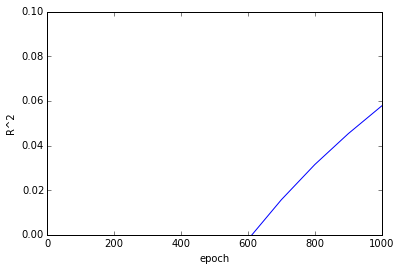

In [16]:
ts, r2s = list(zip( *tfl.r2_progress ))
plt.plot(ts, r2s)
plt.xlabel("epoch")
plt.ylabel("R^2")
plt.ylim([0, 0.1* np.ceil(10*max(r2s))])
pass

In [11]:
test_X, test_Y = X3[trainsamples:], y[trainsamples:].as_matrix()

In [18]:
tfl = tflasso(checkpoint_dir = "./cubiclasso/")
tfl.transform( test_X, test_Y, load = True)

print( tfl.loss )
r2 = 1- tfl.loss/test_Y.var()
r2

loading a session
13.0988


0.20946671081424684

In [ ]:
pf3.powers_()

In [ ]:
W1 = tfl.get_params()["W1"][0]
ncoef = len(W1)
xlabels = np.array( get_labels(pf3) )

forder = np.array([len(x) for x in xlabels])


fig, axs = plt.subplots(3,figsize = (14, 5))
fig.subplots_adjust(hspace=.5)
for nn in range(3):
    valid =( forder == (nn+1))
    print(sum(valid))
    x_ =  np.arange(ncoef)[valid]
    y_ = np.log10( abs(W1[valid]) )
    axs[nn].scatter(x_, y_ )
    axs[nn].scatter( x_[y_>-3], y_[y_>-3], 25, "r" )
    #axs[nn].stem( x_[y_>-3], y_[y_>-3], markerfmt = "ro" )
    if nn < 2:
        axs[nn].set_xticks(x_ )
        axs[nn].set_xticklabels([repr(x) for x in xlabels[valid]], rotation = 90)
    else:
        axs[nn].set_xticks(x_[::4] )
        axs[nn].set_xticklabels([repr(x) for x in xlabels[valid][::4]], rotation = 90)
pass

In [ ]:
plt.stem?

In [ ]:
W1 = tfl.get_params()["W1"][0]
print(len(W1))
plt.stem( np.arange(len(W1)), np.log10( abs(W1)) )
plt.stem( np.arange(len(W1))[np.log10(W1)>-3], np.log10(W1)[np.log10(W1)>-3], markerfmt = "ro" )